<a href="https://colab.research.google.com/github/oyjuffer/DL-Final/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install -q git+https://github.com/huggingface/transformers datasets


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [6]:
from datasets import *
from transformers import ViTFeatureExtractor
from transformers import ViTModel
from transformers import TrainingArguments, Trainer
from transformers.modeling_outputs import SequenceClassifierOutput
import numpy as np
import pandas as pd 
import torch.nn as nn
import pickle
from matplotlib import pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.metrics import confusion_matrix

# File loading

In [7]:
# Load the dataset from the emotion-detection-fer folder
# This contains two folders, test and train, each with 7 folders, one for each emotion.
# Load data as rgb images label as [img, label] in a pandas dataframe for both test and train

import os
import cv2

string_labels = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

def load_data(data_dir):
    data = []
    for emotion in os.listdir(data_dir):
        for item in os.listdir(os.path.join(data_dir, emotion)):
            img = cv2.imread(os.path.join(data_dir, emotion, item))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(int).tolist()
            # Convert emotion label to integer label
            index = string_labels.index(emotion)
            data.append([img, index])
    return pd.DataFrame(data, columns=['img', 'label'])

train_df = load_data('emotion-detection-fer/train')
val_df = load_data('emotion-detection-fer/test')

In [8]:
val_df.head()

,img,label
0,"[[[188, 188, 188], [190, 190, 190], [195, 195,...",3
1,"[[[51, 51, 51], [56, 56, 56], [50, 50, 50], [5...",3
2,"[[[115, 115, 115], [141, 141, 141], [145, 145,...",3
3,"[[[28, 28, 28], [25, 25, 25], [22, 22, 22], [1...",3
4,"[[[203, 203, 203], [165, 165, 165], [128, 128,...",3


## Preprocessing



I finetune ViT on the Facial Expression Recognition 2013 (FER-2013) dataset, which consists of 35.887 48x48 pixel grayscale images representing 7 different emotions.
It is preprocessed using `ViTFeatureExtractor`, which resizes every image to the resolution that the model expects, i.e. 224x224, and normalizes the channels.

Dataset: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

Dataset Paper: https://arxiv.org/pdf/1307.0414.pdf



As opposed to the CNN transfer learning, the smallest pretained weights are only available for images of 244x244, not 96x96.

In [9]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

/usr/local/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [10]:
print(len(train_df))
print(len(val_df))

28709
7178


In [11]:
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)

In [12]:
# image size 
np.array(train_ds[0]["img"]).shape

(48, 48, 3)

Second preprocessing step using the ViT feature extractor

In [13]:
def preprocess_images(examples):
    """ Prepare datasets for vision transformer 
    input: dataset with images in their orignal size 
    output: dataset with pixelvalues computed by the feature extractor added """
    # get batch of images
    images = examples['img']
    # convert to list of NumPy arrays of shape (C, H, W)
    images = [np.array(image, dtype=np.uint8) for image in images]
    images = [np.moveaxis(image, source=-1, destination=0) for image in images]
    # preprocess and add pixel_values
    inputs = feature_extractor(images=images)
    examples['pixel_values'] = inputs['pixel_values']

    return examples

In [14]:
# features of the new dataset with an additional column for the preprocess 224x224x3 images 
features = Features({
    'label': ClassLabel(names=string_labels),
    'img': Array3D(dtype="int64", shape=(3,48,48)),
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
})

preprocessed_train_ds = train_ds.map(preprocess_images, batched=True, batch_size=1, features=features)
with open('preprocessed_train_ds.pickle', 'wb') as handle:
    pickle.dump(preprocessed_train_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)
preprocessed_val_ds = val_ds.map(preprocess_images, batched=True, features=features)
with open('preprocessed_val_ds.pickle', 'wb') as handle:
   pickle.dump(preprocessed_val_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)

# load preprocessed datasets
# with open('preprocessed_train_ds.pickle', 'rb') as handle:
#     preprocessed_train_ds = pickle.load(handle)
# with open('preprocessed_val_ds.pickle', 'rb') as handle:
#     preprocessed_val_ds = pickle.load(handle)

preprocessed_train_ds

FileNotFoundError: [Errno 2] Failed to open local file '/var/folders/5p/j2sf71mn1csfx38_374kdnz80000gn/T/tmptnvu4ier.arrow'. Detail: [errno 2] No such file or directory

In [ ]:
# final image size
print(len(preprocessed_train_ds[0]["pixel_values"]))       
print(len(preprocessed_train_ds[0]["pixel_values"][0]))     
print(len(preprocessed_train_ds[0]["pixel_values"][0][0]))  

3
224
224


## Looking at the Data 
Let's quickly look at some samples of processed data as well as the label distribution.

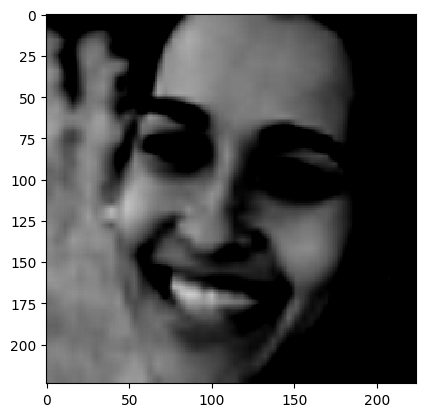

happy


In [ ]:
# show a single image from the dataset
data_for_image = np.array(preprocessed_train_ds[0]["pixel_values"])
data_for_image[data_for_image < 0] = 0 

plt.imshow(np.transpose(data_for_image, (1,2,0)), interpolation='nearest')
plt.show()

print(string_labels[preprocessed_train_ds[0]["label"]])

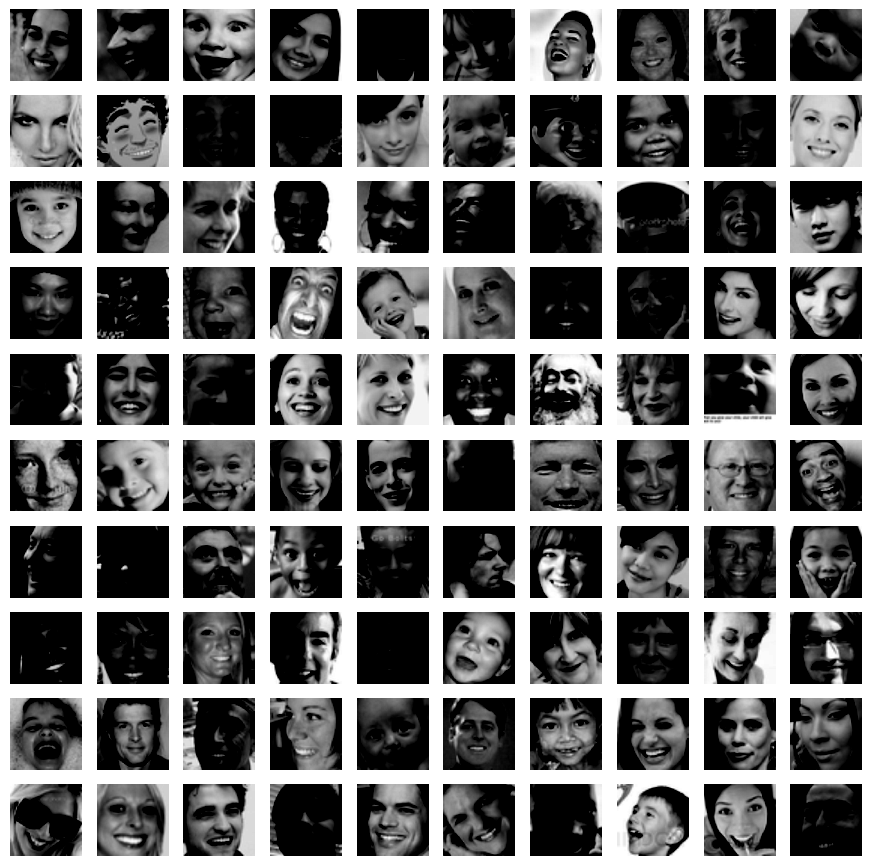

In [ ]:
# show 100 images from the dataset
fig, axes = plt.subplots(10,10, figsize=(11,11))
for i,ax in enumerate(axes.flat):
  data_for_image = np.array(preprocessed_train_ds[i]["pixel_values"])
  data_for_image[data_for_image < 0] = 0 
  ax.imshow(np.transpose(data_for_image, (1,2,0)), interpolation='nearest')
  ax.set_axis_off()


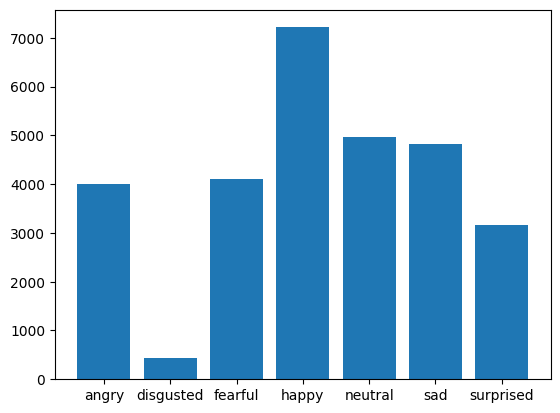

In [ ]:
# distribution of labels in the training set
keys, counts = np.unique(preprocessed_train_ds["label"], return_counts=True)
plt.bar(string_labels, counts)
plt.show()

## Defining the model

The model architecture is defined in PyTorch, with dropout and a linear layer added on top of the ViT model's output of the special CLS token representing the input picture. 


In [ ]:
class ViTForImageClassification(nn.Module):
    #define architecture
    def __init__(self, num_labels=len(string_labels)):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    #define a forward pass through that architecture + loss computation
    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

Training uses the standard HuggingFace [Trainer](https://huggingface.co/transformers/main_classes/trainer.html) interface. 

In [ ]:
metric_name = "accuracy"

args = TrainingArguments(
    f"test-cifar-10",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=6,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
)

ValueError: --load_best_model_at_end requires the save and eval strategy to match, but found
- Evaluation strategy: epoch
- Save strategy: steps

In [ ]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
model = ViTForImageClassification()

ImportError: 
ViTModel requires the PyTorch library but it was not found in your environment.
However, we were able to find a TensorFlow installation. TensorFlow classes begin
with "TF", but are otherwise identically named to our PyTorch classes. This
means that the TF equivalent of the class you tried to import would be "TFViTModel".
If you want to use TensorFlow, please use TF classes instead!

If you really do want to use PyTorch please go to
https://pytorch.org/get-started/locally/ and follow the instructions that
match your environment.


In [ ]:
trainer = Trainer(
    model = model,
    args = args,
    train_dataset = preprocessed_train_ds,
    eval_dataset = preprocessed_val_ds,
    compute_metrics = compute_metrics,
)

## Fine-tuning ViT


Fine-tuning the model by calling the `train()` method

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.984800,0.996220,0.637225
2,0.780800,0.910926,0.668153
3,0.599600,0.901057,0.682363
4,0.450400,0.947739,0.690164
5,0.302200,1.033552,0.679298
6,0.207200,1.085887,0.680691


TrainOutput(global_step=9156, training_loss=0.5893453882999845, metrics={'train_runtime': 4962.4647, 'train_samples_per_second': 29.504, 'train_steps_per_second': 1.845, 'total_flos': 0.0, 'train_loss': 0.5893453882999845, 'epoch': 6.0})